# 캘리포니아 주택 가격 예측 모델 만들기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## 1. 데이터 가져오기

In [2]:
housing = pd.read_csv('./datasets/housing.csv')

## 2. 데이터 훑어보기

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [19]:
# longitude : 경도
# latitude : 위도
# median_income : 중간 소득
# ocean_proximity : 바다와의 거리
# median_house_value => 우리가 예측하고자 하는 값

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

**범주형 특성 탐색**

In [6]:
housing.describe(include='object')

,ocean_proximity
count,20640
unique,5
top,<1H OCEAN
freq,9136


In [7]:
housing['ocean_proximity'].value_counts() # 빈도수

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

**수치형 특성 탐색**

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**수치형 특성 히스토그램**

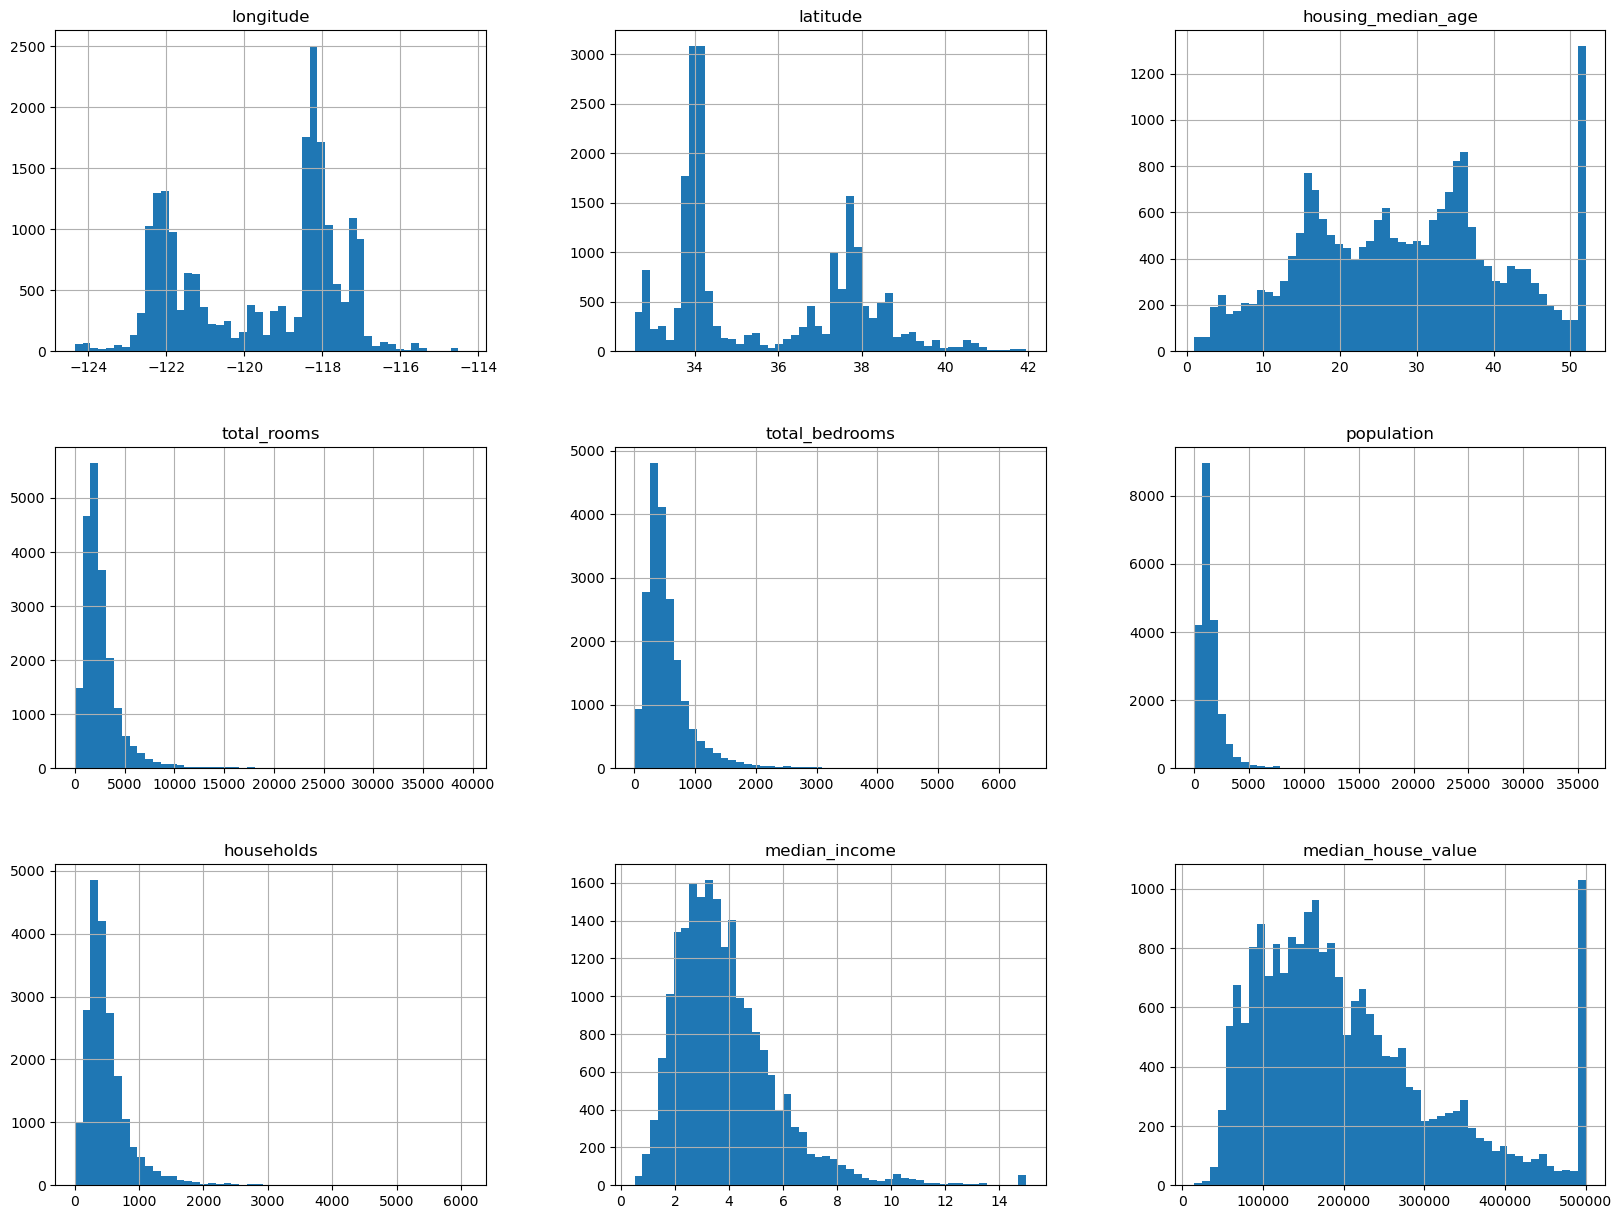

In [9]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

- housing_median_age나 median_house_value 오른쪽의 큰 직선 bar는 큰 값을 일괄적으로 처리했기 때문

## 3. 데이터 세트 분리
- 훈련 데이터/ 테스트 데이터
- 소득분위(median_incom)를 기준으로 데이터 정리

**계층적 샘플링(Straityfied sampling)**

In [10]:
bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf] # np.inf : 끝까지 지정
labels = [1, 2, 3, 4, 5] # 소득 구간에 따른 이름
housing['income_cat'] = pd.cut(housing['median_income'], bins=bins, labels=labels) # 소득 카테고리 컬럼 추가

In [11]:
housing['income_cat'].value_counts() # 빈도수

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

In [12]:
housing['income_cat'].value_counts() / len(housing) # 상대도수

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split 

# 무작위 샘플 추출
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) 

# 계층적 샘플 추출
strat_train_set, strat_test_set = train_test_split(housing, stratify=housing['income_cat'], test_size=0.2, random_state=42) 
# stratify(계층화) : train, test의 housing['income_cat']이 원본과 같은 비율로 데이터가 존재하도록 설정(범주형 데이터만 가능)

In [28]:
# 원본 데이터와 같은 비율을 갖는 테스트 데이터 확인
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

**데이터 되돌리기**

In [14]:
# 'income_cat' 열 삭제
strat_train_set = strat_train_set.drop('income_cat', axis=1)
strat_test_set = strat_test_set.drop('income_cat', axis=1)

## 4. 데이터 탐색

In [15]:
# 훈련 세트만 대상으로 데이터 탐색, 테스트 세트는 최종 예측에만 사용
housing = strat_train_set.copy()

### 4.1 지리적 데이터 시각화

In [16]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


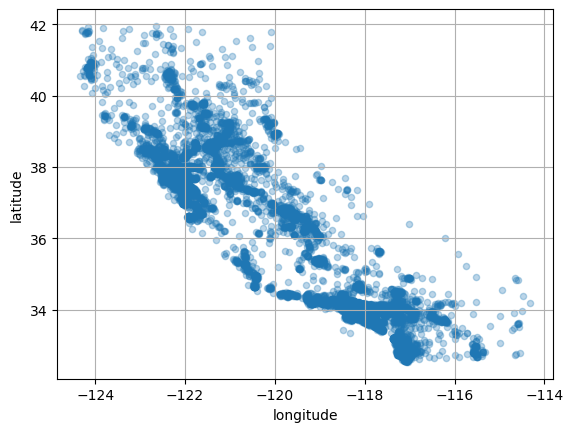

In [17]:
# 'longitue' : 동서
# 'latitude' : 남북
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, grid=True)
plt.show()

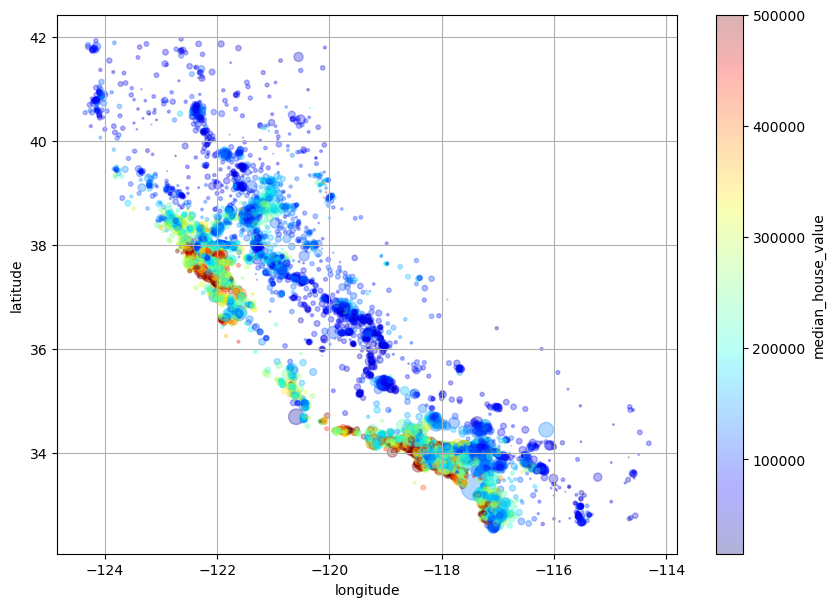

In [18]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, grid=True,
            c='median_house_value', cmap='jet', figsize=(10, 7), # c(color) : color을 통해 정보(주택 가격) 추가
            s=housing['population']/100) # s(size) : 동그라미 size를 통해 정보(t상대적 인구 수) 추가
plt.show()

**지리적 데이터 분석 결과** : 해안가이면서 밀집 지역일수록 주택 가격이 높음

### 4.2 상관관계 조사

- 상관계수

In [19]:
# 모든 수치형 특성간의 상관계수 확인(타겟 포함)
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


In [20]:
# 중간 주택 가격(타겟)과 다른 특성들 간의 상관관계 확인
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

- 산점도

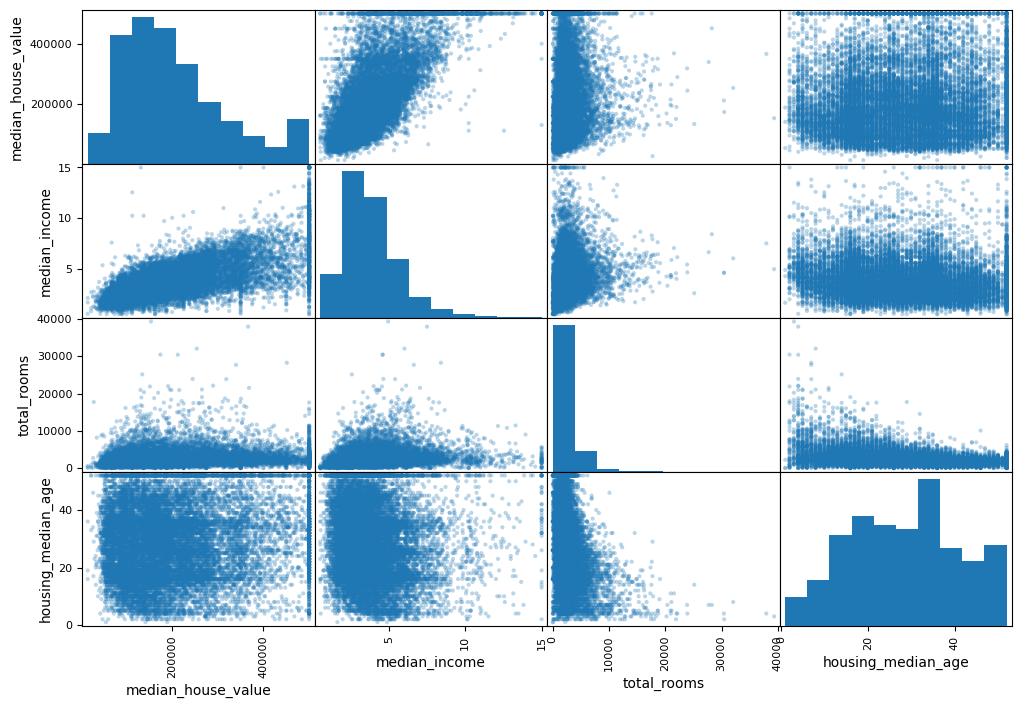

In [21]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
# pd.plotting.scatter_matrix : scatter를 매트릭스 형태로 그리기
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8), alpha=0.3) 
plt.show()

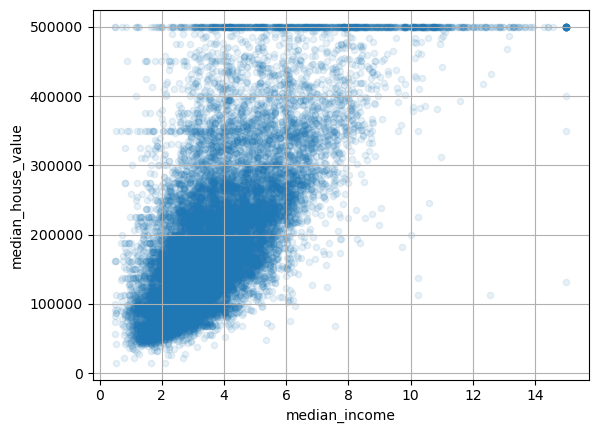

In [22]:
# 중간 주택 가격(타겟)과 중간소득의 산점도
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, grid=True)
plt.show()

### 4.3 특성 조합을 실험

In [23]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [24]:
# 특성 조합 컬럼 추가
# 가구 당 방의 갯수
housing['rooms_per_households'] = housing['total_rooms']/housing['households']
housing['rooms_per_households']

# 전체 방에서 침실 차지 비율
housing['bedrooms_per_rooms'] = housing['total_bedrooms']/housing['total_rooms']
housing['bedrooms_per_rooms']

# 가구 당 인구 수
housing['population_per_households'] = housing['population']/housing['households']
housing['population_per_households']

12655    3.168555
15502    2.623698
2908     2.223333
14053    1.859213
20496    3.167241
           ...   
15174    2.023976
12661    3.363188
19263    2.662791
19140    2.411178
19773    3.172589
Name: population_per_households, Length: 16512, dtype: float64

In [25]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value           1.000000
median_income                0.687151
rooms_per_households         0.146255
total_rooms                  0.135140
housing_median_age           0.114146
households                   0.064590
total_bedrooms               0.047781
population_per_households   -0.021991
population                  -0.026882
longitude                   -0.047466
latitude                    -0.142673
bedrooms_per_rooms          -0.259952
Name: median_house_value, dtype: float64

In [26]:
# 가구 당 방이 많을수록 집 가격이 높다(양의 상관관계 커짐)
# 인구는 큰 영향 없음
# 방 당 침실이 많을수록 집 가격이 낮다(음의 상관관계 커짐) -> 게스트하우스?

## 5. 데이터 전처리

In [27]:
# strat_train_set (데이터 탐색 후 전처리)
# strat_test_set ( 최종 예측)

In [28]:
# 특성(X)과 레이블(y) 분리
housing = strat_train_set.drop('median_house_value', axis=1) # 특성(타겟 없앤 데이터들)
housing_label = strat_train_set['median_house_value'].copy() # 레이블(타겟)

In [29]:
housing.shape, housing_label.shape

((16512, 9), (16512,))

### 5.1 데이터 전처리(1) - 결손값 처리

**결손값(Null/NaN) 처리 방법**

- 옵션1 : 해당 구역(행) 제거
- 옵션2 : 전체 특성(열) 삭제
- 옵션3 : 어떤 값으로 대체(0, 평균, 중간값 등)


**scikit-learn의 전처리기를 이용하여 옵션3 을 처리**

In [30]:
# scikit_learn 전처리기(변환기) 예시
# PolynomialFeatures : 다항 특성 추가
# StandardScaler : 표준화(평균 0, 분산 1)
# MinMaxScaler : 정규화(최소 0, 최대 1)
# LabelEncoder, OrdinalEncoder : 숫자로 변환 -> 범주형 데이터
# OneHotEncoder : OneHot 인코딩(표현하고 싶은 단어의 인덱스에 1의 값을 부여하고, 다른 인덱스에는 0을 부여) -> 범주형 데이터
# SimpleImputer : 누락된 데이터 대체

# 함수를 이용한 전처리기
# 나만의 전처리기

In [31]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [32]:
# 수치형 데이터만 준비
housing_num = housing.drop('ocean_proximity', axis=1)
housing_num.columns

# 데이터 타입으로도 가능
# housing_num = housing.select_dtypes(include=[np.number])
# housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [33]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median') # 변환기 생성(strategy='median' : 중앙값으로 대체)
imputer.fit(housing_num) # 변환할 준비(중앙값 구하기)

SimpleImputer(strategy='median')

In [34]:
imputer.statistics_ # statistics : 통계량, 이때는 모든 컬럼에 대한 중앙값

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [35]:
# 위의 imputer가 구한 중앙값과 동일
housing_num.median()

longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64

In [36]:
X = imputer.transform(housing_num) # 변환(중앙값으로 대체)

In [37]:
# transform의 결과는 numpy
X

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [38]:
# numpy를 df로 바꿔 누락값 확인
# X_df = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
# X_df.info() # 누락값 채워짐

### 5.2 데이터 전처리(2) - 데이터 인코딩
- 데이터 인코딩을 하는 이유는 머신러닝에서 수치값만 기대하기 때문(문자형->수치형)

In [39]:
housing_cat = housing[['ocean_proximity']] # 2차원 데이터 프레임으로 준비

#### (1) 레이블 인코딩

In [40]:
# pandas
pd.factorize(housing['ocean_proximity']) # 1차원 데이터만 가능

(array([0, 1, 0, ..., 2, 2, 0], dtype=int64),
 Index(['INLAND', 'NEAR OCEAN', '<1H OCEAN', 'NEAR BAY', 'ISLAND'], dtype='object'))

In [41]:
# scikit-learn
from sklearn.preprocessing import OrdinalEncoder # LabelEncoder : 1차원 데이터만 가능

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit_transform(housing_cat) # 2차원 데이터

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

#### (2) 원핫 인코딩
숫자의 크기가 모델 훈련과정에서 잘못된 영향을 줄 수 있으므로 원핫 인코딩

In [42]:
# pandas
pd.get_dummies(housing_cat)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
12655,0,1,0,0,0
15502,0,0,0,0,1
2908,0,1,0,0,0
14053,0,0,0,0,1
20496,1,0,0,0,0
...,...,...,...,...,...
15174,1,0,0,0,0
12661,0,1,0,0,0
19263,1,0,0,0,0
19140,1,0,0,0,0


In [43]:
# scikit-learn
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False) # sparse=False : 압축된 데이터를 보여지게 함
onehot_encoder.fit_transform(housing_cat)

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### 5.3 데이터 전처리(3) - 특성 스케일링
- 표준화 (Z score Standardize) : 평균 0, 표준편차 1
- 정규화 (Min Max Scaling) : 0~1 사이로 정규화 (참고 : 특잇값에 영향을 받음)
- 로그 스케일링 : 데이터의 분포가 왜곡되어 있을때 주로 사용

In [44]:
arr = np.arange(9).reshape(3, 3)
arr

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [45]:
# 표준화 공식
Z_arr = (arr - arr.mean()) / arr.std()
Z_arr.mean(), Z_arr.std() # 평균 0, 표준편차 1

(0.0, 1.0)

In [46]:
# min-max 스케일링 정규화 공식
M_arr = (arr - arr.min()) / (arr.max() - arr.min())
M_arr.min(), M_arr.max() # 최솟값 0, 최댓값 1

(0.0, 1.0)

In [47]:
# pandas 함수
def zscore_standardize(arr):
    return (arr - arr.mean()) / arr.std()

def minmax_normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [48]:
# scikit-learn

# (1) 표준화
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std = std_scaler.fit_transform(housing_num)
housing_num_std.mean(0), housing_num_std.std(0) # 컬럼 별 평균, 표준편차(axis=0)

(array([-5.24924634e-15,  2.81159678e-16,  8.77850764e-17, -1.54914841e-17,
                    nan,  6.45478503e-19, -1.05428155e-17,  1.14841384e-16]),
 array([ 1.,  1.,  1.,  1., nan,  1.,  1.,  1.]))

In [49]:
# (2) 정규화
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
housing_num_mm = min_max_scaler.fit_transform(housing_num)
housing_num_mm.min(0), housing_num_mm.max(0)

(array([ 0.,  0.,  0.,  0., nan,  0.,  0.,  0.]),
 array([ 1.,  1.,  1.,  1., nan,  1.,  1.,  1.]))

In [50]:
# (3) 로그 스케일링 -> 선형 회귀 모델이 사용하면 성능이 향상됨
from sklearn.preprocessing import FunctionTransformer # 로그함수 사용할 때

log_transformer = FunctionTransformer(np.log) # 로그 변환기
log_population = log_transformer.fit_transform(housing_num['population'])

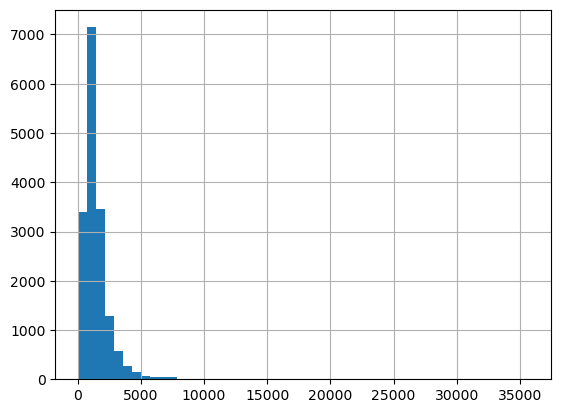

In [51]:
# 로그 변환 전
housing_num['population'].hist(bins=50)
plt.show()

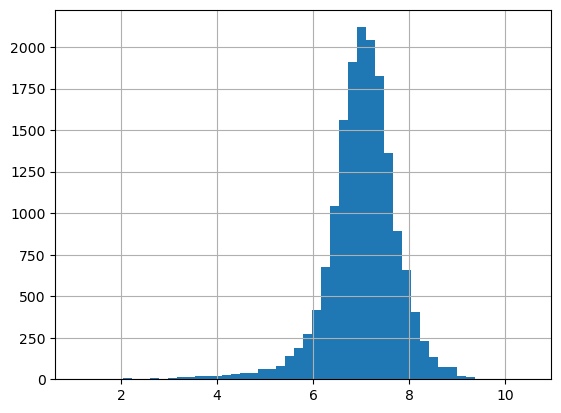

In [52]:
# 로그 변환 후
log_population.hist(bins=50)
plt.show()

### 5.4 데이터 전처리(4) - 변환 파이프라인

In [53]:
housing.columns # 9개 특성

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [54]:
from sklearn.pipeline import Pipeline

```
# 1. 나만의 변환기 만들기(Upgrade version)

from sklearn.base import BaseEstimator, TransformerMixin

class 나만의 변환기(BaseEstimator, TransformerMixin):
    def __init__(self):
        # todo
    
    def fit(self, X, y=None):
        # todo
        return self
    
    def transform(self, X):
        # todo
        return 변형된 데이터
        
# 2. fit과 transform 함수 위주로 코드 채우기

# 3. 변환기 초기 값이 필요하다면 __init__ 함수 채우기

```

**수치형 파이프라인 (1)**
- 특성 조합 실험(비율 특성 추가)

In [65]:
# housing['rooms_per_households'] = housing['total_rooms']/housing['households']
# housing['bedrooms_per_rooms'] = housing['total_bedrooms']/housing['total_rooms']
# housing['population_per_households'] = housing['population']/housing['households']

# 특성의 조합으로 또 다른 비율을 만들어내는 변환기 만들기

from sklearn.base import BaseEstimator, TransformerMixin

rooms_idx = 0
bedrooms_idx = 1
population_idx = 2
households_idx = 3

class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_households = X[:, rooms_idx]/X[:, households_idx]
        bedrooms_per_rooms = X[:, bedrooms_idx]/X[:, rooms_idx]
        population_per_households = X[:, population_idx]/X[:, households_idx]
        return np.c_[rooms_per_households, bedrooms_per_rooms, population_per_households]

# (1) 변환기
# adder = CombinedAttributeAdder()
# adder.fit_transform(housing[['total_rooms', 'households', 'total_bedrooms', 'population']].values)

# (2) 변환기가 들어간 pipeline
ratio_add_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), # 누락된 값 처리하는 변환기
                               ('ratio_adder', CombinedAttributeAdder()), # 특성의 비율들을 추가하는 변환기
                               ('std_scaler', StandardScaler())]) # 표준화

X_txed = ratio_add_pipeline.fit_transform(housing[['total_rooms', 'households', 'total_bedrooms', 'population']])
X_txed.shape # 3개의 새로운 특성

(16512, 3)

In [67]:
# 참고 - 나만의 변환기를 만드는 함수
# 변환기 = FunctionTransformer(함수)
# 변환기.fit_transform()

# (1) 변환기에 DataFrame이 입력으로 들어왔을 경우
ratio_transformer = FunctionTransformer(lambda X:X.iloc[:, 0]/X.iloc[:, 1])
ratio_transformer.fit_transform(housing[['total_rooms', 'total_bedrooms']])

# (2) 변환기에 Numpy가 입력으로 들어왔을 경우
ratio_transformer = FunctionTransformer(lambda X:X[:, 0]/X[:, 1])
ratio_transformer.fit_transform(housing[['total_rooms', 'total_bedrooms']].values)

12655    4.859473
15502    6.222222
2908     5.219355
14053    3.616570
20496    5.473684
           ...   
15174    5.414297
12661    5.556259
19263    4.259036
19140    5.439655
19773    4.860360
Length: 16512, dtype: float64

**수치형 파이프라인 (2)**
- 왜곡된 수치형 데이터 로그 변환 -> 분포가 정규 분포에 가깝게 됨

In [71]:
log_attribs = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

# (1) 변환기
# log_transformer = FunctionTransfromer(np.log)
# log_transformer.fit_transform(housing[log_attribs])

# (2) 변환기가 들어가 pipeline
log_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), # 누락된 값 처리하는 변환기
                               ('log_transformer', FunctionTransformer(np.log)), # 로그 변환한 변환기
                               ('std_scaler', StandardScaler())]) # 표준화

X_txed = log_pipeline.fit_transform(housing[log_attribs])
X_txed.shape

(16512, 5)

**수치형 파이프라인 (3)**
- 지리 정보를 이용한 유사도 특성 추가

In [72]:
# 군집(clustering)
from sklearn.cluster import KMeans

kmeans = KMeans(10, random_state=42) # 임의로 n_cluster = 10으로 잡음, 튜닝을 통해 조절 가능
kmeans.fit(housing[['longitude', 'latitude']]) # 비지도 학습, .fit(X)로 학습 시키기

KMeans(n_clusters=10, random_state=42)

In [73]:
kmeans.labels_ # 각 지리 정보가 어느 그룹(군집)에 들어가 있는지 알 수 있음

array([7, 5, 8, ..., 2, 2, 4])

In [75]:
kmeans.labels_.shape, np.unique(kmeans.labels_) # 16512개의 샘플이 0~9까지의 한 그룹에 속해 있음

((16512,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [76]:
kmeans.cluster_centers_ # 각 그룹마다 대표가 되는 지리 정보

array([[-117.66409486,   33.91442292],
       [-120.98844304,   37.79105063],
       [-122.32346397,   37.94601742],
       [-119.5898263 ,   36.61137717],
       [-123.05567568,   40.52867568],
       [-116.92679819,   32.95492238],
       [-118.30520362,   34.05764275],
       [-121.2775063 ,   38.92382032],
       [-119.70374456,   34.96576197],
       [-121.9340267 ,   37.24695011]])

In [85]:
cluster_centers = kmeans.cluster_centers_ # 10개의 중심점 위치
cluster_labels = np.unique(kmeans.labels_) # 10개의 unique한 그룹 이름들

In [86]:
cluster_centers

array([[-117.66409486,   33.91442292],
       [-120.98844304,   37.79105063],
       [-122.32346397,   37.94601742],
       [-119.5898263 ,   36.61137717],
       [-123.05567568,   40.52867568],
       [-116.92679819,   32.95492238],
       [-118.30520362,   34.05764275],
       [-121.2775063 ,   38.92382032],
       [-119.70374456,   34.96576197],
       [-121.9340267 ,   37.24695011]])

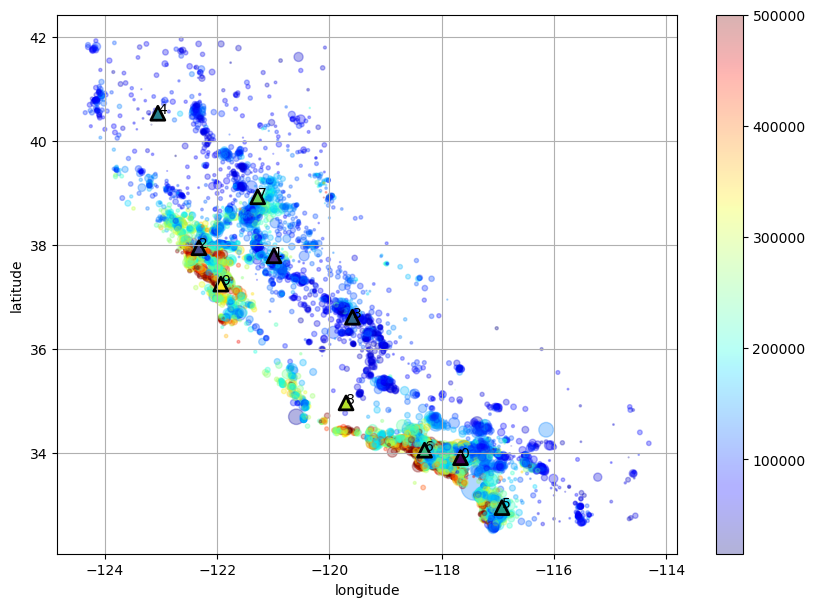

In [88]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, grid=True,
            c=housing_label, cmap='jet', figsize=(10, 7), # c(color) : color을 통해 정보(주택 가격) 추가
            s=housing['population']/100) # s(size) : 동그라미 size를 통해 정보(t상대적 인구 수) 추가

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c=cluster_labels, marker='^', linewidth=2, edgecolors='k', s=100)
for cluster_label in cluster_labels:
    plt.annotate(cluster_label, (cluster_centers[cluster_label, 0], cluster_centers[cluster_label, 1])) # 표시, x좌표, y좌표

plt.show()

In [91]:
from sklearn.metrics.pairwise import rbf_kernel

# rbf_kernel(원본특성, 랜드마크(군집의 중심점), gamma=)
# gamma가 클수록 종모양이 얇아짐(조금만 랜드마크에서 벗어나도 유사도가 급격히 떨어짐)

similarity = rbf_kernel(housing[['longitude', 'latitude']], kmeans.cluster_centers_, gamma=1.0) 
similarity

array([[3.39100207e-16, 4.70606426e-01, 3.41288868e-01, ...,
        8.21704201e-01, 1.49339869e-07, 1.57968861e-01],
       [4.19743483e-01, 1.85074889e-16, 3.10368965e-22, ...,
        1.27265504e-22, 6.52101701e-05, 7.67854643e-18],
       [1.81004302e-02, 6.39175594e-05, 2.72830170e-08, ...,
        2.19154649e-08, 5.46639786e-01, 6.80173887e-06],
       ...,
       [1.00871499e-20, 3.27312567e-02, 6.69476236e-01, ...,
        9.87790063e-02, 6.40913408e-10, 1.29882891e-01],
       [3.93638770e-20, 4.08137730e-02, 7.60132364e-01, ...,
        9.06940324e-02, 1.75381109e-09, 1.79641844e-01],
       [2.36525729e-25, 2.30216848e-03, 1.60802331e-02, ...,
        1.59073756e-01, 3.51997011e-14, 5.77139977e-04]])

In [93]:
similarity[:3].round(2) # OneHotEncoding처럼 1과 0으로 딱 나누는 것이 아니라 각 특성마다 유사도를 따져서 소수점 2자리까지 표시

array([[0.  , 0.47, 0.34, 0.  , 0.  , 0.  , 0.  , 0.82, 0.  , 0.16],
       [0.42, 0.  , 0.  , 0.  , 0.  , 0.9 , 0.12, 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.  , 0.16, 0.  , 0.  , 0.1 , 0.  , 0.55, 0.  ]])

In [104]:
# 위의 과정을 나만의 변환기로 만들기

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None): 
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
        
    def fit(self, X):
        # 랜드마크로 사용할 군집의 중심점 찾기
        self.kmeans = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans.fit(X) # kmeans.cluster_centers_ : 군집의 중심점
        return self
    
    def transform(self, X):
        # 유사도 특성 추가 with rbf_kernel()
        return rbf_kernel(X, kmeans.cluster_centers_, self.gamma)
    
cluster_similarity = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
X_txed = cluster_similarity.fit_transform(housing[['longitude', 'latitude']])
X_txed.shape # 10개의 유사도 특성 추가됨 확인

(16512, 10)

In [105]:
X_txed[:3].round(2)

array([[0.  , 0.47, 0.34, 0.  , 0.  , 0.  , 0.  , 0.82, 0.  , 0.16],
       [0.42, 0.  , 0.  , 0.  , 0.  , 0.9 , 0.12, 0.  , 0.  , 0.  ],
       [0.02, 0.  , 0.  , 0.16, 0.  , 0.  , 0.1 , 0.  , 0.55, 0.  ]])

**수치형 파이프라인 (4)**
- 위에서 처리되지 않은 나머지 특성들에 대해 처리할 파이프라인

In [106]:
# 남은 수치형 데이터에 대해 기본 변환 수행
# 누락된 데이터를 중앙값으로 대체 -> 표준화

from sklearn.pipeline import Pipeline
# Pipeline('이름', 변환기), 2개 이상이면 리스트로 묶어줌
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), # (1)
                        ('std_scaler', StandardScaler()) # (2)
                        ])
X_txed = num_pipeline.fit_transform(housing[['housing_median_age']]) # pipeline의 중간결과 확인하고 싶을 때
X_txed.shape

(16512, 1)

In [108]:
# 범주형 데이터
# 원핫 인코딩

oh_encoder = OneHotEncoder(sparse=False)
X_txed = oh_encoder.fit_transform(housing_cat)
X_txed.shape # 1개의 범주 데이터가 5개의 특성으로 변환

(16512, 5)

In [109]:
oh_encoder.categories_ # 5개의 특성

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [110]:
# ColumnTransformer : 수치형 파이프라인과 범주형 변환기를 한번에 연결할 파이프라인
# ColumnTransformer([이름, 변환기(파이프라인), 컬럼명])

from sklearn.compose import ColumnTransformer

ratio_attribs = ['total_rooms', 'households', 'total_bedrooms', 'population']
log_attribs = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
geo_attribs = ['longitude', 'latitude']
num_attrib = ['housing_median_age']
cat_attrib = ['ocean_proximity']

full_pipeline = ColumnTransformer([('ratio_add_pipeline', ratio_add_pipeline, ratio_attribs), # 4 -> 3
                                   ('log_pipeline', log_pipeline, log_attribs), # 5 -> 5
                                   ('cluster_similarity', cluster_similarity, geo_attribs), # 2 -> 10
                                   ('num_pipeline', num_pipeline, num_attrib), # 1 -> 1
                                   ('oh_encoder', OneHotEncoder(), cat_attrib) # 1 -> 5
                                  ])

In [111]:
housing_prepared = full_pipeline.fit_transform(housing) # 9 -> 24

In [112]:
housing.shape, housing_prepared.shape # full_pipeline의 변환 과정 참조(3+5+10+1+5=24)

((16512, 9), (16512, 24))

In [118]:
from sklearn import set_config
set_config(display='diagram')

full_pipeline

ColumnTransformer(transformers=[('ratio_add_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('ratio_adder',
                                                  CombinedAttributeAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['total_rooms', 'households', 'total_bedrooms',
                                  'population']),
                                ('log_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log_transformer',
                                                  Func...
                                                  StandardScaler())]),
                                 ['total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cluster_similarity',
                                 ClusterSimilarity(random_state=42),
                                 ['longitude', 'latitude']),
                                ('num_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['housing_median_age']),
                                ('oh_encoder', OneHotEncoder(),
                                 ['ocean_proximity'])])

## 6. 모델 선택과 훈련

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [114]:
lin_reg = LinearRegression()
tree_reg = DecisionTreeRegressor(random_state=42)
rf_reg = RandomForestRegressor(random_state=42)

In [115]:
# cross_val_score(모델, 특성, 정답, 성능측정지표, 폴드 수)

# LinearRegression 교차검증
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
# scoring='neg_mean_squared_error'(음수값 계산)를 쓰는 이유 : scoring 매개변수에 클수록 좋은 함수를 기대하기 때문에 -mse를 쓰고 나서 나중에 다시 -를 곱해준다
lin_rmse = np.sqrt(-lin_scores.mean())
lin_rmse

69480.31753506926

In [116]:
# DecisionTree 교차검증
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
tree_rmse = np.sqrt(-tree_scores.mean())
tree_rmse

64452.95018558239

In [117]:
# RandomForest 교차검증 -> 가장 성능 좋게 나옴
rf_scores = cross_val_score(rf_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
rf_rmse = np.sqrt(-rf_scores.mean())
rf_rmse

46358.980435999256

## 7. 모델 세부 튜닝

**그리드 탐색**

In [119]:
from sklearn.model_selection import GridSearchCV
# GridSearchCV : 직접 모델의 하이퍼 파라미터의 값을 리스트로 입력, 값마다 예측 성능을 평가하여 최적의 하이퍼 파라미터 값을 찾음

rf_reg = RandomForestRegressor(random_state=42)

param_grid = {'n_estimators' : [30, 50, 100], 'max_features' : [2, 4, 6, 8]} # 3 * 4 = 12가지 조합의 파라미터로 설정된 모델 준비
# n_estimators : 결정 트리의 갯수, max_features : 최적의 분할을 위해 고려할 최대 feature 개수

grid_search = GridSearchCV(rf_reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1) # 3 * 4 * 5 = 60번의 학습과 검증
%time grid_search.fit(housing_prepared, housing_label)

Wall time: 2min 48s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [30, 50, 100]},
             scoring='neg_mean_squared_error')

In [120]:
grid_search.best_params_ 

{'max_features': 6, 'n_estimators': 100}

In [121]:
grid_search.best_estimator_ # 예측기

RandomForestRegressor(max_features=6, random_state=42)

In [122]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)
    
# RandomForest 교차검증 : 46358.980435999256
# 그리드 튜닝 후 : 44439.32622223688

47478.18928151229 {'max_features': 2, 'n_estimators': 30}
46758.613072913875 {'max_features': 2, 'n_estimators': 50}
46558.379812647756 {'max_features': 2, 'n_estimators': 100}
45484.54427842164 {'max_features': 4, 'n_estimators': 30}
45109.43044616188 {'max_features': 4, 'n_estimators': 50}
44815.00136269128 {'max_features': 4, 'n_estimators': 100}
45219.95542889343 {'max_features': 6, 'n_estimators': 30}
44833.58162208996 {'max_features': 6, 'n_estimators': 50}
44439.32622223688 {'max_features': 6, 'n_estimators': 100}
45902.64245093499 {'max_features': 8, 'n_estimators': 30}
45448.03431557417 {'max_features': 8, 'n_estimators': 50}
45158.301310615345 {'max_features': 8, 'n_estimators': 100}


**랜덤 탐색**

In [123]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators':randint(low=1, high=200), 'max_features':randint(low=1, high=8)}

random_search = RandomizedSearchCV(rf_reg, param_distribs, n_iter=10, scoring='neg_mean_squared_error', cv=5, n_jobs=-1) 
# n_iter : 반복 횟수

%time random_search.fit(housing_prepared, housing_label)

Wall time: 2min 8s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DEC3F8D850>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001DEC3F8D7F0>},
                   scoring='neg_mean_squared_error')

In [124]:
random_search.best_params_

{'max_features': 6, 'n_estimators': 65}

In [125]:
random_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=65, random_state=42)

In [126]:
cv_results = random_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)
    
# RandomForest 교차검증 : 46358.980435999256
# 그리드 튜닝 후 : 44439.32622223688 - best!
# 랜덤 탐색 튜닝 후 : 44601.93841474783

49113.28362649223 {'max_features': 1, 'n_estimators': 66}
48025.740123064614 {'max_features': 3, 'n_estimators': 12}
48999.629175906986 {'max_features': 1, 'n_estimators': 93}
44813.31749098995 {'max_features': 4, 'n_estimators': 95}
44800.21809080133 {'max_features': 4, 'n_estimators': 102}
50207.050140764215 {'max_features': 5, 'n_estimators': 5}
46502.959119614665 {'max_features': 2, 'n_estimators': 126}
48918.98385754591 {'max_features': 1, 'n_estimators': 130}
44729.651385315454 {'max_features': 4, 'n_estimators': 166}
44601.93841474783 {'max_features': 6, 'n_estimators': 65}


In [127]:
best_model = grid_search.best_estimator_

In [ ]:
# 참고
# 지수분포
# https://en.wikipedia.org/wiki/Exponential_distribution

# 로그 유니폼 분포
# https://en.wikipedia.org/wiki/Reciprocal_distribution

# param_distribs = {
#         'kernel': ['linear', 'rbf'],
#         'C': reciprocal(20, 200000), # 로그유니폼분포
#         'gamma': expon(scale=1.0), # 지수분포
#     }

# reciprocal : 주어진 범위 안에서 균등 분포로 샘플링. 하이퍼파라미터의 스케일에 대해 잘 모를 때 사용
# expon : 하이퍼파라미터의 스케일에 대해 어느 정도 알고 있을 때 사용

**모델의 특성 중요도**
- 특성 중요도는 트리 기반 모델만 제공

In [134]:
feature_importances = best_model.feature_importances_

In [131]:
ratio_attribs2 = ['rooms_per_households', 'bedrooms_per_rooms', 'population_per_households'] # 4 -> 3
log_attribs2 = ['log_total_rooms', 'log_total_bedrooms', 'log_population', 'log_households', 'log_median_income']
geo_attribs2 = [f'cluster {i} simil' for i in range(10)] # 2 -> 10, ex) 'cluster 1 simil'
num_attrib2 = ['housing_median_age']

onehot_encoder = full_pipeline.named_transformers_['oh_encoder']
cat_attrib2 = list(onehot_encoder.categories_[0])

total_attribs = ratio_attribs2 + log_attribs2 + geo_attribs2 + num_attrib2 + cat_attrib2
total_attribs

['rooms_per_households',
 'bedrooms_per_rooms',
 'population_per_households',
 'log_total_rooms',
 'log_total_bedrooms',
 'log_population',
 'log_households',
 'log_median_income',
 'cluster 0 simil',
 'cluster 1 simil',
 'cluster 2 simil',
 'cluster 3 simil',
 'cluster 4 simil',
 'cluster 5 simil',
 'cluster 6 simil',
 'cluster 7 simil',
 'cluster 8 simil',
 'cluster 9 simil',
 'housing_median_age',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [130]:
onehot_encoder = full_pipeline.named_transformers_['oh_encoder']
onehot_encoder.categories_[0]

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [135]:
feature_importances

array([1.25393636e-01, 4.83079776e-02, 4.22071799e-02, 1.36798565e-02,
       1.18431052e-02, 1.23651041e-02, 1.10930102e-02, 2.54353159e-01,
       2.62312974e-02, 1.81964167e-02, 2.33596584e-02, 6.18790132e-02,
       1.83008353e-02, 3.11982563e-02, 4.73437528e-02, 3.10303332e-02,
       3.36229448e-02, 3.01561151e-02, 2.31130427e-02, 1.40957824e-02,
       1.13515121e-01, 5.48723569e-05, 2.10859197e-03, 6.55093739e-03])

In [137]:
sorted(zip(feature_importances, total_attribs), reverse=True)

[(0.25435315920345497, 'log_median_income'),
 (0.12539363580313115, 'rooms_per_households'),
 (0.11351512134632666, 'INLAND'),
 (0.06187901318157606, 'cluster 3 simil'),
 (0.04830797763412687, 'bedrooms_per_rooms'),
 (0.0473437528100265, 'cluster 6 simil'),
 (0.042207179942855076, 'population_per_households'),
 (0.033622944830984464, 'cluster 8 simil'),
 (0.031198256335234292, 'cluster 5 simil'),
 (0.031030333224512405, 'cluster 7 simil'),
 (0.030156115091742902, 'cluster 9 simil'),
 (0.026231297435540483, 'cluster 0 simil'),
 (0.02335965840082691, 'cluster 2 simil'),
 (0.02311304268605201, 'housing_median_age'),
 (0.0183008353198335, 'cluster 4 simil'),
 (0.018196416681026003, 'cluster 1 simil'),
 (0.014095782400862823, '<1H OCEAN'),
 (0.013679856478397714, 'log_total_rooms'),
 (0.012365104100741266, 'log_population'),
 (0.011843105166527005, 'log_total_bedrooms'),
 (0.011093010216068783, 'log_households'),
 (0.006550937388060034, 'NEAR OCEAN'),
 (0.002108591965161056, 'NEAR BAY'),
 (

## 8. 모델 예측과 성능 평가
**테스트 데이터는 훈련 데이터와 같은 과정의 데이터 처리를 해야 한다 -> 파이프라인 사용**

- 테스트 데이터 변환

In [138]:
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test.shape, y_test.shape

((4128, 9), (4128,))

In [139]:
# 훈련 데이터에서 전처리 했던 것들
# 수치 데이터 -> 4개의 파이프라인 모음
# 범주 데이터 -> 원핫인코딩

X_test_prepared = full_pipeline.transform(X_test) # 훈련 모델의 pipeline을 사용해서 테스트 데이터 변경 시 fit이 아닌 transform
X_test_prepared.shape

(4128, 24)

- 예측과 평가

In [140]:
from sklearn.metrics import mean_squared_error # MSE 구하기

final_predictions = best_model.predict(X_test_prepared)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False) # squared=False : RMSE 구하기
final_rmse

42723.89097023599

- 테스트 데이터 변환과 예측 한번에

In [141]:
# 전처리와 모델을 pipeline으로 연결해서 예측
from sklearn.metrics import mean_squared_error

full_pipeline_with_predictor = Pipeline([('preparation', full_pipeline), 
                                        ('final', best_model)
                                        ])
final_predictions = full_pipeline_with_predictor.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False) # squared=False : RMSE 구하기
final_rmse

42723.89097023599

**일반화 오차 추정**
- 테스트 RMSE에 대한 95% 신뢰 구간

In [145]:
from scipy.stats import t # t분포

# 추정량(오차의 제곱들의 합)
squared_errors = (final_predictions - y_test)**2

# 95% 신뢰구간
confidence = 0.95

# 표본의 크기
n = len(squared_errors)

# 자유도(degree of freedom)
dof = n - 1 

# 추정량의 평균
m_squared_error = np.mean(squared_errors)

# 표본의 표준편차(비편형 분산으로 구함)
sample_std = np.std(squared_errors, ddof=1) # n-1로 나눈 표준편차

# 표준 오차
std_err = (sample_std/n)**0.5

# t.interval(신뢰구간, 자유도, 추정량의 평균(or MSE), 표준오차) # 신뢰구간 계산
mse_ci = t.interval(confidence, dof, m_squared_error, std_err)
rmse_ci = np.sqrt(mse_ci)
rmse_ci # RMSE에 대한 95% 신뢰 구간

array([42723.86510096, 42723.9168395 ])

## 9. 모델 저장

In [146]:
import joblib

joblib.dump(full_pipeline_with_predictor, 'my_model_pkl') # 파이프라인과 예측기를 한번에 저장

['my_model_pkl']

In [148]:
# ... 시간이 흐른 뒤 사용
from sklearn.metrics import mean_squared_error

loaded_model = joblib.load('my_model_pkl')
final_predictions2 = loaded_model.predict(X_test)
mean_squared_error(y_test, final_predictions2, squared=False) # 같은 결과

42723.89097023599